# Approche hybride avec LightFM

## Données

### Chargement du dataframe global

In [1]:
import pandas as pd

df_clicks = pd.read_parquet("./data/df_final.parquet")
print("✅ Dataset rechargé avec succès.")

✅ Dataset rechargé avec succès.


In [2]:
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321484,0.910162,-0.413011,0.680835,-0.418409,-0.526443,0.305625,-0.307805,-0.606366,-0.650556
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,-1.001013,0.797471,-0.492230,-0.305857,-1.307835,0.354010,0.696917,-0.486316,0.017210,-1.563045
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,...,-0.269690,0.873445,0.194144,0.056367,-0.431036,-0.020383,-0.376942,0.814494,0.709722,-1.030146
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,...,0.144034,-2.457183,-1.500929,-1.807169,-0.208940,-0.671638,-0.407914,2.561696,-1.379031,-1.877568
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,...,-1.163678,-0.230112,-2.132536,-0.729996,0.581913,-0.559910,-0.354824,-0.914158,-0.064399,-0.354175


## Matrice utilisateur-item

| Situation | Stratégie sur la matrice user-item | Raison |
|----------|-------------------------------------|--------|
| **Collaborative pur** (pas de features) | 🔥 Maximiser l'intensité : `alpha` élevé, `weighting='log'`, **pas de normalisation** | Cela amplifie les différences de préférence et donne du signal fort à LightFM |
| **Hybride (avec user/item features)** | ⚖️ Normalisation cohérente des valeurs dans `[0, 1]` sur **toutes les matrices** (y compris interactions) | Cela évite que les features soient écrasées ou négligées par un déséquilibre d’échelle | 

<br>
C'est le principe de <b>l'équilibrage des signaux dans les systèmes hybrides de recommandation</b>. Si on normalise seulement les features mais la matrice user-item reste avec des valeurs hautes les features seront ignées par le le modèle. Si on normalise tout il faut éviter d'écraser la variance <br>

🛠️ Bonnes pratiques à appliquer<br>
| Élément | Bonne échelle |
|--------|----------------|
| `user_features` | `[0, 1]` (via MinMax ou OneHot) |
| `item_features` | `[0, 1]` (MinMax + embeddings déjà compressés) |
| `interaction_matrix` | `[0, 1]` uniquement si features aussi présentes (sinon garder amplitudes fortes) |

In [3]:
from scipy.sparse import coo_matrix
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def build_user_item_matrix_for_lightfm(df_clicks, weighting="log", alpha=40.0, normalize=False):
    """
    Construit une matrice CSR (utilisateurs × articles) pour LightFM avec pondération et normalisation optionnelles.

    Paramètres :
    - df_clicks : DataFrame avec 'user_id' et 'click_article_id'
    - weighting : 'log' ou 'linear'
    - alpha : pondération log
    - normalize : False, 'minmax', 'standard', 'log', 'user_minmax', 'user_standard', ou fonction custom

    Retourne :
    - user_item_matrix : matrice CSR
    - user_mapping : dict {user_id → index}
    - item_mapping : dict {click_article_id → index}
    """
    # Agrégation des clics
    df_user_item = (
        df_clicks.groupby(['user_id', 'click_article_id'])
        .size()
        .reset_index(name='click_strength')
    )

    # Mappings
    print("🔄 Construction des dictionnaires d’indexation...")
    user_ids = df_user_item['user_id'].unique()
    item_ids = df_user_item['click_article_id'].unique()

    user_mapping = {uid: idx for idx, uid in enumerate(tqdm(user_ids, desc="🔢 Mapping users"))}
    item_mapping = {iid: idx for idx, iid in enumerate(tqdm(item_ids, desc="🧾 Mapping articles"))}

    df_user_item['user_idx'] = df_user_item['user_id'].map(user_mapping)
    df_user_item['item_idx'] = df_user_item['click_article_id'].map(item_mapping)

    # Pondération
    if weighting == "log":
        df_user_item['weight'] = 1.0 + alpha * np.log1p(df_user_item['click_strength'])
        print(f"🧮 Pondération logarithmique avec alpha={alpha}")
    elif weighting == "linear":
        df_user_item['weight'] = df_user_item['click_strength'].astype(float)
        print("🧮 Pondération linéaire")
    else:
        raise ValueError("Le paramètre 'weighting' doit être 'log' ou 'linear'.")

    # Normalisation
    if normalize:
        print(f"📏 Normalisation des poids : {normalize}")
        if normalize == 'minmax':
            scaler = MinMaxScaler()
            df_user_item['weight'] = scaler.fit_transform(df_user_item[['weight']])
        elif normalize == 'standard':
            scaler = StandardScaler()
            df_user_item['weight'] = scaler.fit_transform(df_user_item[['weight']])
        elif normalize == 'log':
            df_user_item['weight'] = np.log1p(df_user_item['weight'])
        elif normalize == 'user_minmax':
            df_user_item['weight'] = df_user_item.groupby('user_idx')['weight'].transform(
                lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
            )
        elif normalize == 'user_standard':
            df_user_item['weight'] = df_user_item.groupby('user_idx')['weight'].transform(
                lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
            )
        elif callable(normalize):
            df_user_item['weight'] = normalize(df_user_item['weight'].values)
        else:
            raise ValueError("Le paramètre 'normalize' doit être False, 'minmax', 'standard', 'log', "
                             "'user_minmax', 'user_standard' ou une fonction.")

    # Matrice sparse
    print("📐 Construction de la matrice sparse (CSR)...")
    user_item_matrix = coo_matrix(
        (df_user_item['weight'],
         (df_user_item['user_idx'], df_user_item['item_idx']))
    ).tocsr()

    print(f"✅ Matrice prête : {user_item_matrix.shape} (utilisateurs × articles)")
    return user_item_matrix, user_mapping, item_mapping


In [4]:
# Création de la matrice et des mappages d'index
# # Pas de normalisation (collaborative pur)
# build_user_item_matrix_for_lightfm(df_clicks, normalize=False)
# # Hybride avec normalisation MinMax
# build_user_item_matrix_for_lightfm(df_clicks, normalize='minmax')
# # Hybride avec log compression
# build_user_item_matrix_for_lightfm(df_clicks, normalize='log')

user_item_matrix, user_mapping, item_mapping = build_user_item_matrix_for_lightfm(df_clicks, normalize=False)

🔄 Construction des dictionnaires d’indexation...


🧾 Mapping articles: 100%|██████████| 46033/46033 [00:00<00:00, 4875543.45it/s]


🧮 Pondération logarithmique avec alpha=40.0
📐 Construction de la matrice sparse (CSR)...
✅ Matrice prête : (322897, 46033) (utilisateurs × articles)


<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>Note :</strong> Contrairement à Implicit on ne filtre pas les utilisateurs ayant moins de 3 interactions afin de ne pas occulter la situation correspond à beaucoup de cas: utilisateur peu actif. Les métriques seront sans doute moins bonnes qu'avec un filtrage
</div>

## Split LOO

In [5]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix

def leave_one_out_split(interactions):
    """
    Réalise un split Leave-One-Out sur une matrice utilisateurs × articles.
    
    Paramètres :
    - interactions : csr_matrix (n_users x n_items)

    Retourne :
    - train : csr_matrix (interactions moins 1 par utilisateur)
    - test : csr_matrix (1 interaction par utilisateur)
    """
    assert isinstance(interactions, csr_matrix), "La matrice d'entrée doit être au format CSR."

    print("🔄 Split Leave-One-Out en cours...")

    interactions = interactions.tolil()  # Accès rapide ligne par ligne
    n_users, n_items = interactions.shape

    train = lil_matrix(interactions.shape, dtype=np.float32)
    test = lil_matrix(interactions.shape, dtype=np.float32)

    rng = np.random.default_rng(seed=42)  # Pour reproductibilité

    for user_id in range(n_users):
        user_interactions = interactions.rows[user_id]
        user_data = interactions.data[user_id]

        if len(user_interactions) >= 2:
            idx = rng.integers(0, len(user_interactions))

            test_item = user_interactions[idx]
            test_value = user_data[idx]

            # Ajouter au test
            test[user_id, test_item] = test_value

            # Ajouter le reste au train
            for i, item in enumerate(user_interactions):
                if i != idx:
                    train[user_id, item] = user_data[i]
        else:
            for i, item in enumerate(user_interactions):
                train[user_id, item] = user_data[i]

    print(f"✅ Split terminé :\n - Train shape : {train.shape}\n - Test shape : {test.shape}")
    return train.tocsr(), test.tocsr()


In [6]:
# Jeux de train et test
train_matrix, test_matrix = leave_one_out_split(user_item_matrix)

🔄 Split Leave-One-Out en cours...


KeyboardInterrupt: 

<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>✨ Fonctionnement :</strong> tolil() ➔ convertit temporairement en LIL (list of lists). C'est une structure de matrice creuse qui stocke pour chaque ligne une liste de colonnes non-nulles, une autre list associée qui contient les valeurs de ces colonnes. Donc par ligne on garde: un tableau des indices de colonnes non nulles, un tableau des valeurs correspondantes. Format adapté pour construire, CSR est meilleur pour les calculs (matmul) et la mise en oeuvre du modèle
</div>

## Métriques

### Métriques de recommantion

👉 NDCG@k (Normalized Discounted Cumulative Gain) doit être calculé à la main car LightFM ne le donne pas directement.

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
from joblib import Parallel, delayed

def ndcg_at_k(model, test_interactions, train_interactions=None, 
              user_features=None, item_features=None, 
              k=5, num_threads=8):
    """
    Calcule le NDCG@k utilisateur par utilisateur (vectorisé + parallélisé).
    """
    n_users, n_items = test_interactions.shape
    test_csr = test_interactions.tocsr()
    train_csr = train_interactions.tocsr() if train_interactions is not None else None

    def compute_ndcg(user_id):
        true_items = test_csr[user_id].indices
        if len(true_items) == 0:
            return None

        scores = np.array(model.predict(
            user_id,
            np.arange(n_items),
            user_features=user_features,
            item_features=item_features,
            num_threads=1
        )).copy() # rend l'array modifiable

        # Masquer les items vus pendant le training
        if train_csr is not None:
            train_items = train_csr[user_id].indices
            scores[train_items] = -np.inf

        top_k_items = np.argpartition(-scores, k)[:k]
        top_k_items = top_k_items[np.argsort(-scores[top_k_items])]  # tri final

        relevances = np.isin(top_k_items, true_items).astype(int)
        dcg = np.sum(relevances / np.log2(np.arange(2, k + 2)))
        idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(true_items), k) + 2)))

        return dcg / idcg if idcg > 0 else 0.0

    results = Parallel(n_jobs=num_threads, backend="threading")(
        delayed(compute_ndcg)(user_id)
        for user_id in tqdm(range(n_users), total=n_users, desc="Calcul NDCG@k (parallèle)")
    )

    results = [r for r in results if r is not None]  # supprimer les utilisateurs sans clics
    return np.mean(results) if results else 0.0


### Erreurs RMSE et MAE

📚 Note: LightFM est principalement conçu pour optimiser du ranking (ordre des items) et travailler sur des interactions implicites (clic, vue, achat = 1 ou pas = 0).<br>
RMSE (Root Mean Squared Error) et MAE (Mean Absolute Error) sont normalement utilisés sur :<br>
- des valeurs continues (ex : prédiction d'une note sur 5).
- des modèles de prédiction de score explicite (comme SVD dans Surprise).
  
<br>
👉 Or LightFM peut quand même prédire un score implicite (predict(user, item)) continu. Ce sont des scores relatifs, pas des probabilités calibrées. <br>
👉 Donc on peut comparer ces scores aux clics réels (1 s'il a cliqué, 0 sinon). On a bien une proximité entre le score prédit et le clic réel.<br>
<b>Métriques données pour information, elles ne constituent pas un critère pour LightFM </b>

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from joblib import Parallel, delayed

def compute_rmse_mae(model, test_interactions, train_interactions=None,
                     user_features=None, item_features=None,
                     num_threads=8):
    """
    Calcule RMSE et MAE pour un modèle LightFM (multithreadé et sécurisé).
    """
    n_users, n_items = test_interactions.shape
    test_csr = test_interactions.tocsr()
    train_csr = train_interactions.tocsr() if train_interactions is not None else None

    def compute_user_predictions(user_id):
        true_items = test_csr[user_id].indices
        if len(true_items) == 0:
            return [], []

        scores = np.array(model.predict(
            user_id,
            np.arange(n_items),
            user_features=user_features,
            item_features=item_features,
            num_threads=1  # sécurisé pour joblib threading
        )).copy()  # évite le buffer read-only

        if train_csr is not None:
            train_items = train_csr[user_id].indices
            scores[train_items] = -np.inf

        y_t = [1] * len(true_items)
        y_p = [scores[item] for item in true_items]

        return y_t, y_p

    results = Parallel(n_jobs=num_threads, backend="threading")(
        delayed(compute_user_predictions)(user_id)
        for user_id in tqdm(range(n_users), total=n_users, desc="Calcul RMSE/MAE (parallèle)")
    )

    # Fusion des résultats
    y_true, y_pred = [], []
    for y_t, y_p in results:
        y_true.extend(y_t)
        y_pred.extend(y_p)

    if not y_true:
        raise ValueError("Aucune interaction à évaluer.")

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae


## Entrainement (baseline: matrice user-item)

In [ ]:
from lightfm import LightFM
from itertools import product
from lightfm.evaluation import precision_at_k

def grid_search_lightfm(train_matrix, test_matrix, k=5, num_threads=4, epochs=30):
    """
    Effectue une recherche exhaustive sur une grille LightFM et retourne le meilleur modèle basé sur Hit@k.

    Paramètres :
    - train_matrix : matrice d'entraînement CSR
    - test_matrix : matrice de test CSR
    - k : nombre d'articles recommandés pour évaluation
    - num_threads : nombre de threads pour LightFM
    - epochs : nombre d'époques d'entraînement

    Retourne :
    - best_model : modèle LightFM entraîné
    - best_params : dict des meilleurs hyperparamètres
    - best_score : Hit@k du meilleur modèle
    """
    param_grid = {
        'loss': ['warp', 'bpr'],
        'no_components': [32, 64],
        'learning_rate': [0.01, 0.05, 0.1]
    }

    best_score = 0.0
    best_model = None
    best_params = None

    all_combinations = list(product(
        param_grid['loss'],
        param_grid['no_components'],
        param_grid['learning_rate']
    ))

    print(f"🔍 Recherche sur {len(all_combinations)} combinaisons...")

    for loss, no_components, learning_rate in all_combinations:
        print(f"\n🚀 Entraînement modèle : loss={loss}, components={no_components}, lr={learning_rate}")

        model = LightFM(
            loss=loss,
            no_components=no_components,
            learning_rate=learning_rate,
            random_state=42
        )

        model.fit(train_matrix, epochs=epochs, num_threads=num_threads, verbose=False)

        hit5 = precision_at_k(
            model,
            test_matrix,
            train_interactions=train_matrix,
            k=k,
            num_threads=num_threads
        ).mean()

        print(f"🎯 Hit@{k} : {hit5:.4f}")

        if hit5 > best_score:
            best_score = hit5
            best_model = model
            best_params = {
                'loss': loss,
                'no_components': no_components,
                'learning_rate': learning_rate
            }

    print("\n✅ Recherche terminée !")
    print(f"🏆 Meilleur modèle : {best_params} avec Hit@{k} = {best_score:.4f}")

    return best_model, best_params, best_score


In [ ]:
# best_model, best_params, best_score = grid_search_lightfm(train_matrix, test_matrix, k=5)

In [ ]:
# Provisoire (pour ne pas avoir à refaire la mise au point)
best_params = {'loss': 'bpr', 'no_components': 32, 'learning_rate': 0.05}

### Ré-entrainement du meilleur modèle

In [ ]:
import os
import pandas as pd
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from tqdm.notebook import tqdm

#### 🎯 Entrainement avec les paramètres optimaux

In [ ]:
def train_lightfm_model(train_matrix, best_params, user_features=None, item_features=None, epochs=50, num_threads=8):
    model = LightFM(
        loss=best_params['loss'],
        no_components=best_params['no_components'],
        learning_rate=best_params['learning_rate'],
        random_state=42
    )
    for epoch in tqdm(range(epochs), desc="Entraînement LightFM"):
        model.fit_partial(
            train_matrix,
            user_features=user_features,
            item_features=item_features,
            epochs=1,
            num_threads=num_threads
        )
    return model


#### 🎯 Evaluation avec échantillonage

In [ ]:
import numpy as np
import os
import pandas as pd
from scipy.sparse import csr_matrix
from lightfm.evaluation import precision_at_k, recall_at_k

def evaluate_lightfm_model(model, train_matrix, test_matrix,
                           user_features=None, item_features=None,
                           k=5, num_threads=8,
                           experiment_name="user-item",
                           results_file="results/experiments_lightfm.csv"):
    """
    Évalue un modèle LightFM sur l'ensemble des utilisateurs,
    avec ou sans user/item features. Enregistre les résultats dans un fichier CSV.
    """

    # Matrices d'interactions
    test_subset = test_matrix
    train_subset = train_matrix
    user_features_subset = user_features
    item_features_subset = item_features

    # 🎯 Top-K métriques intégrées
    hit = precision_at_k(model, test_subset, train_interactions=train_subset,
                         user_features=user_features_subset,
                         item_features=item_features_subset,
                         k=k, num_threads=num_threads).mean()

    recall = recall_at_k(model, test_subset, train_interactions=train_subset,
                         user_features=user_features_subset,
                         item_features=item_features_subset,
                         k=k, num_threads=num_threads).mean()

    # 📈 NDCG custom
    print("Shape passée à ndcg_at_k:", test_subset.shape)
    ndcg = ndcg_at_k(model, test_subset, train_interactions=train_subset,
                     user_features=user_features_subset,
                     item_features=item_features_subset,
                     k=k, num_threads=num_threads)

    # 📉 RMSE / MAE custom
    rmse, mae = compute_rmse_mae(model, test_subset, train_interactions=train_subset,
                                 user_features=user_features_subset,
                                 item_features=item_features_subset,
                                 num_threads=num_threads)

    # 📋 Résultats
    new_result = {
        'Experiment': experiment_name,
        'Hit@5': hit,
        'Recall@5': recall,
        'NDCG@5': ndcg,
        'RMSE': rmse,
        'MAE': mae
    }

    # 💾 Sauvegarde CSV
    os.makedirs(os.path.dirname(results_file), exist_ok=True)
    if os.path.exists(results_file):
        results_df = pd.read_csv(results_file)
        results_df = pd.concat([results_df, pd.DataFrame([new_result])], ignore_index=True)
    else:
        results_df = pd.DataFrame([new_result])
    results_df.to_csv(results_file, index=False)
    print(f"📄 Résultats mis à jour dans {results_file}")

    return new_result


#### 🎯 Résultat avec matrice utilisateur-item

In [ ]:
model = train_lightfm_model(train_matrix, best_params, epochs=50)

In [ ]:
results = evaluate_lightfm_model(model, train_matrix, test_matrix,
                                 user_features=None, item_features=None)
print(results)

✅ Résumé du setup : <br>
- ⚙️ Modèle : LightFM (avec ou sans features)
- 📊 Métriques :
    - precision_at_k, recall_at_k (LightFM natif)
    - ndcg_at_k, rmse, mae (custom, full Numpy + Joblib, optimisé)
- 🔁 Évaluation complète sur tout le dataset
- ⚡ Temps total d’évaluation : ≈ 10 minutes
- 💾 Résultats loggés proprement dans un fichier CSV

## Recalcul de la matrice d'interactions pour l'hybride

In [ ]:
user_item_matrix_hybrid, user_mapping, item_mapping = build_user_item_matrix_for_lightfm(
    df_clicks, weighting="log", alpha=40.0, normalize="user_minmax"
)
train_matrix_hybrid, test_matrix_hybrid = leave_one_out_split(user_item_matrix_hybrid)


In [ ]:
model_hybrid = train_lightfm_model(train_matrix_hybrid, best_params, epochs=50)

In [ ]:
results_hybrid = evaluate_lightfm_model(model, train_matrix, test_matrix_hybrid,
                                 user_features=None, item_features=None)
print(results_hybrid)

## Calcul de la matrice de features utilisateur features engineering
On calcule feature par feature en adaptant la normalisation

#### 🚀 1 : Nombre de sessions par utilisateur

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_sessions(df_clicks):
    """
    Extrait et normalise le nombre de sessions par utilisateur (lissage log1p + MinMax).
    
    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_sessions_scaled']
    """
    sessions_per_user = df_clicks.groupby('user_id')['session_id'].nunique().reset_index()
    sessions_per_user.columns = ['user_id', 'num_sessions']
    
    # Log transform pour lisser
    sessions_per_user['num_sessions_log'] = np.log1p(sessions_per_user['num_sessions'])

    # MinMax scaling
    scaler = MinMaxScaler()
    sessions_per_user['num_sessions_scaled'] = scaler.fit_transform(
        sessions_per_user[['num_sessions_log']]
    )

    return sessions_per_user[['user_id', 'num_sessions_scaled']]


In [ ]:
sessions_per_user = extract_number_of_sessions(df_clicks)
print(sessions_per_user.head())

#### 🚀 2 : Nombre total de clics par utilisateur

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_clicks(df_clicks):
    """
    Extrait et normalise le nombre total de clics par utilisateur (log1p + MinMax).

    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_clicks_scaled']
    """
    clicks_per_user = df_clicks.groupby('user_id').size().reset_index(name='num_clicks')

    # Log transform
    clicks_per_user['num_clicks_log'] = np.log1p(clicks_per_user['num_clicks'])

    # MinMax scaling
    scaler = MinMaxScaler()
    clicks_per_user['num_clicks_scaled'] = scaler.fit_transform(
        clicks_per_user[['num_clicks_log']]
    )

    return clicks_per_user[['user_id', 'num_clicks_scaled']]


In [ ]:
clicks_per_user = extract_number_of_clicks(df_clicks)
print(clicks_per_user.head())

#### 🚀 3 : Nombre d'articles distincts cliqués par utilisateur

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_distinct_articles(df_clicks):
    """
    Extrait et normalise le nombre d'articles distincts cliqués par utilisateur (log1p + MinMax).

    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_distinct_articles_scaled']
    """
    distinct_articles_per_user = df_clicks.groupby('user_id')['click_article_id'].nunique().reset_index()
    distinct_articles_per_user.columns = ['user_id', 'num_distinct_articles']

    # Log transform
    distinct_articles_per_user['num_distinct_articles_log'] = np.log1p(distinct_articles_per_user['num_distinct_articles'])

    # MinMax scaling
    scaler = MinMaxScaler()
    distinct_articles_per_user['num_distinct_articles_scaled'] = scaler.fit_transform(
        distinct_articles_per_user[['num_distinct_articles_log']]
    )

    return distinct_articles_per_user[['user_id', 'num_distinct_articles_scaled']]


In [ ]:
distinct_articles_per_user = extract_number_of_distinct_articles(df_clicks)
print(distinct_articles_per_user.head())

#### 🚀 4 : Heure favorite de connexion par utilisateur - discrétisée

In [ ]:
def extract_favorite_hour(df_clicks):
    """
    Extrait l'heure favorite de connexion basée sur session_start pour chaque utilisateur.
    """
    # Convertir session_start en heure
    df_clicks['session_start_hour'] = pd.to_datetime(df_clicks['session_start'], unit='ms').dt.hour

    # Trouver l'heure favorite (la plus fréquente) pour chaque utilisateur
    favorite_hour_per_user = (
        df_clicks.groupby('user_id')['session_start_hour']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_hour_per_user.columns = ['user_id', 'favorite_hour']

    return favorite_hour_per_user


In [ ]:
favorite_hour_per_user = extract_favorite_hour(df_clicks)
print(favorite_hour_per_user.head())

In [ ]:
def discretize_favorite_hour_6_periods(favorite_hour_df):
    """
    Discrétise l'heure favorite en 6 classes :
    Nuit profonde, Très tôt, Matin, Début après-midi, Fin après-midi, Soirée.
    """
    def map_hour_to_period(hour):
        if 0 <= hour <= 3:
            return 'Nuit_profonde'
        elif 4 <= hour <= 7:
            return 'Très_tôt'
        elif 8 <= hour <= 11:
            return 'Matin'
        elif 12 <= hour <= 15:
            return 'Début_après_midi'
        elif 16 <= hour <= 19:
            return 'Fin_après_midi'
        else:
            return 'Soirée'

    favorite_hour_df['favorite_period'] = favorite_hour_df['favorite_hour'].apply(map_hour_to_period)
    return favorite_hour_df[['user_id', 'favorite_period']]

In [ ]:
favorite_period_per_user = discretize_favorite_hour_6_periods(favorite_hour_per_user)

#### 🚀 5 : Jour favori de connexion

In [ ]:
def extract_favorite_day(df_clicks):
    """
    Extrait le jour favori de connexion (0=lundi, ..., 6=dimanche) pour chaque utilisateur.
    """
    # Convertir session_start en jour de la semaine
    df_clicks['session_start_dayofweek'] = pd.to_datetime(df_clicks['session_start'], unit='ms').dt.dayofweek

    # Trouver le jour favori
    favorite_day_per_user = (
        df_clicks.groupby('user_id')['session_start_dayofweek']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_day_per_user.columns = ['user_id', 'favorite_dayofweek']

    return favorite_day_per_user


In [ ]:
favorite_day_per_user = extract_favorite_day(df_clicks)

#### 🚀 6 : Device préféré

In [ ]:
def extract_favorite_device(df_clicks):
    """
    Extrait le device préféré (le plus utilisé) pour chaque utilisateur.
    """
    favorite_device_per_user = (
        df_clicks.groupby('user_id')['click_deviceGroup']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_device_per_user.columns = ['user_id', 'favorite_device']

    return favorite_device_per_user


#### 🚀 7 : Environnement préféré

In [ ]:
def extract_favorite_environment(df_clicks):
    """
    Extrait l'environnement préféré (web/app) pour chaque utilisateur.
    """
    favorite_environment_per_user = (
        df_clicks.groupby('user_id')['click_environment']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_environment_per_user.columns = ['user_id', 'favorite_environment']

    return favorite_environment_per_user


#### 🚀 8 : Nombre de pays différents

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_countries(df_clicks):
    """
    Extrait et normalise le nombre de pays différents par utilisateur.
    """
    countries_per_user = (
        df_clicks.groupby('user_id')['click_country']
        .nunique()
        .reset_index()
    )
    countries_per_user.columns = ['user_id', 'num_countries']

    countries_per_user['num_countries_log'] = np.log1p(countries_per_user['num_countries'])
    scaler = MinMaxScaler()
    countries_per_user['num_countries_scaled'] = scaler.fit_transform(
        countries_per_user[['num_countries_log']]
    )

    return countries_per_user[['user_id', 'num_countries_scaled']]


In [ ]:
favorite_device_per_user = extract_favorite_device(df_clicks)
favorite_environment_per_user = extract_favorite_environment(df_clicks)
countries_per_user = extract_number_of_countries(df_clicks)

print(favorite_device_per_user.head())
print(favorite_environment_per_user.head())
print(countries_per_user.head())


### Fusion des features

Fusionner toutes les features (num_sessions, num_clicks, num_distinct_articles, favorite_period, favorite_dayofweek, favorite_device, favorite_environment, num_countries).

One-Hot Encoder uniquement les catégorielles :

favorite_period

favorite_dayofweek

favorite_device

favorite_environment

Garder les numériques (num_sessions, num_clicks, num_distinct_articles, num_countries) tels quels - ils ont été normalisés de façon personnalisée.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def build_user_features_df(
    sessions_per_user,
    clicks_per_user,
    distinct_articles_per_user,
    favorite_period_per_user,
    favorite_day_per_user,
    favorite_device_per_user,
    favorite_environment_per_user,
    countries_per_user
):
    """
    Construit le DataFrame final des user features prêt pour LightFM.
    """
    
    # 1. Fusionner tous les DataFrames
    df = sessions_per_user \
        .merge(clicks_per_user, on='user_id') \
        .merge(distinct_articles_per_user, on='user_id') \
        .merge(favorite_period_per_user, on='user_id') \
        .merge(favorite_day_per_user, on='user_id') \
        .merge(favorite_device_per_user, on='user_id') \
        .merge(favorite_environment_per_user, on='user_id') \
        .merge(countries_per_user, on='user_id')

    print(f"📄 Fusion terminée. Shape du DataFrame : {df.shape}")
    
    # 2. Identifier colonnes catégorielles
    categorical_columns = ['favorite_period', 'favorite_dayofweek', 'favorite_device', 'favorite_environment']

    # 3. One-Hot Encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse_output=False pour garder un DataFrame
    encoded_cats = encoder.fit_transform(df[categorical_columns])
    encoded_cat_cols = encoder.get_feature_names_out(categorical_columns)

    encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoded_cat_cols, index=df.index)

    print(f"✅ One-Hot Encoding terminé. Colonnes encodées : {list(encoded_cat_cols)}")
    
    # 4. Rassembler le tout
    df_numeric = df.drop(columns=categorical_columns)

    user_features_df = pd.concat([df_numeric, encoded_cats_df], axis=1)

    print(f"✅ DataFrame final prêt. Shape : {user_features_df.shape}")
    
    return user_features_df


In [ ]:
user_features_df = build_user_features_df(
    sessions_per_user,
    clicks_per_user,
    distinct_articles_per_user,
    favorite_period_per_user,
    favorite_day_per_user,
    favorite_device_per_user,
    favorite_environment_per_user,
    countries_per_user
)

display(user_features_df.head())


### Transformation en matrice sparse (CSR)

In [ ]:
from scipy.sparse import csr_matrix

def user_features_to_csr(user_features_df):
    """
    Transforme le DataFrame user_features en csr_matrix pour LightFM.
    """
    # Enlever user_id pour la matrice
    user_ids = user_features_df['user_id'].values
    features_matrix = csr_matrix(user_features_df.drop(columns=['user_id']).values)

    return features_matrix, user_ids


In [26]:
user_features_matrix, user_ids = user_features_to_csr(user_features_df)

print(user_features_matrix.shape)
print(user_ids[:5])


(322897, 24)
[0 1 2 3 4]


## Calcul de la matrice de features item features engineering

In [32]:
# Datas articles d'origine
import pandas as pd
df_articles = pd.read_csv("./data/articles_metadata.csv", encoding='utf-8')
articles_df = df_articles.drop(columns="publisher_id")
articles_df

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
...,...,...,...,...
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126


In [33]:
import pandas as pd

# 1. Charger les embeddings (index = article_id)
embeddings_df = pd.read_parquet("./data/articles_embeddings_pca.parquet")
embeddings_df.index.name = "article_id"  # au cas où ce ne serait pas explicite

In [34]:
# 3. Fusionner sur l’index
articles_merged = articles_df.join(embeddings_df, how="left")

# Vérification rapide :
print("Dimensions après fusion :", articles_merged.shape)
print("Nombre de NaN dans embeddings :")
print(articles_merged.iloc[:, -embeddings_df.shape[1]:].isna().sum().sum())  # colonne embeddings uniquement

Dimensions après fusion : (364047, 45)
Nombre de NaN dans embeddings :
0


#### 📌 1: Nombre total de clics

#### 📌 2: Nombre d'utilisateurs distincts ayant cliqué l'article

#### 📌 3: Moment du dernier clic

#### 📌 4: Moment du premier clic

#### 📌 5: Delta entre premier et dernier clic

#### 📌 6: Embeddings

In [35]:
# 1. Construire les features d'usage à partir de df_clicks
click_stats = df_clicks.groupby('click_article_id').agg(
    num_clicks=('user_id', 'size'),
    num_users_clicked=('user_id', 'nunique'),
    last_click_timestamp=('click_timestamp', 'max'),
    first_click_timestamp=('click_timestamp', 'min')
)

# Convertir les timestamps en datetime
click_stats['first_click_timestamp'] = pd.to_datetime(click_stats['first_click_timestamp'], errors='coerce')
click_stats['last_click_timestamp'] = pd.to_datetime(click_stats['last_click_timestamp'], errors='coerce')

# Calculer la lifetime
click_stats['lifetime'] = (click_stats['last_click_timestamp'] - click_stats['first_click_timestamp']).dt.total_seconds()

# 2. Fusion avec articles_merged (qui contient déjà les embeddings + métadonnées)
articles_merged = articles_merged.join(click_stats, how='left')

# 3. Remplacer les NaN par 0 pour les articles jamais cliqués
articles_merged.fillna(0, inplace=True)

# 4. Standardiser certaines colonnes
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_to_scale = ['word_count', 'num_clicks', 'num_users_clicked', 'lifetime']

for col in features_to_scale:
    if col in articles_merged.columns:
        articles_merged[col] = scaler.fit_transform(articles_merged[[col]])


/tmp/ipykernel_317/285204074.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  articles_merged.fillna(0, inplace=True)


In [36]:
articles_merged

,article_id,category_id,created_at_ts,words_count,0,1,2,3,4,5,...,36,37,38,39,40,num_clicks,num_users_clicked,last_click_timestamp,first_click_timestamp,lifetime
0,0,0,1513144419000,168,-1.854453,-5.592402,1.708724,-3.835164,1.415795,0.252210,...,-1.099852,-1.175524,1.370632,-0.264816,0.010117,0.000000,0.000000,0,0,0.000000
1,1,1,1405341936000,189,-5.361997,4.122991,-2.357516,-3.428017,-0.431079,3.722260,...,-3.094968,0.075186,0.245235,-1.250343,0.294538,0.000000,0.000000,0,0,0.000000
2,2,1,1408667706000,250,-3.600085,-0.132112,-6.027451,0.985617,0.211965,4.591712,...,-0.877634,0.154883,1.133963,0.946740,-1.811314,0.000000,0.000000,0,0,0.000000
3,3,1,1408468313000,230,-1.158963,7.293352,-5.916713,-1.370524,2.172241,-1.682487,...,-2.076190,-1.690459,-1.122692,0.714619,-1.576244,0.000027,0.000029,1970-01-01 00:25:07.572378399,1970-01-01 00:25:07.572378399,0.000000
4,4,1,1407071171000,162,-1.142884,2.569328,-2.891860,-0.273997,2.913007,5.608970,...,-4.232923,-1.287476,1.053438,-0.486085,-0.144550,0.000000,0.000000,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,364042,460,1434034118000,144,1.901329,7.384367,8.397199,1.004993,-1.738730,-1.755387,...,-0.315928,1.456825,0.264516,-0.300157,-1.453362,0.000000,0.000000,0,0,0.000000
364043,364043,460,1434148472000,463,0.976412,1.577674,6.442007,-3.159583,-14.462528,3.176116,...,-1.345622,1.519320,-0.843804,1.085914,-0.813036,0.000215,0.000234,1970-01-01 00:25:08.181241509,1970-01-01 00:25:07.231045481,0.589568
364044,364044,460,1457974279000,177,1.206031,9.495937,3.033823,-2.910693,-2.307364,0.476110,...,0.548965,0.112421,-1.182815,2.011876,-1.559265,0.000000,0.000000,0,0,0.000000
364045,364045,460,1515964737000,126,11.508031,1.546386,-0.132457,0.648115,2.660047,-2.057655,...,-0.944766,0.708803,-0.905727,1.133456,-1.306856,0.000000,0.000000,0,0,0.000000


### Re-ordonnancement des articles

In [37]:
from scipy import sparse

# 1. Inverser item_mapping pour retrouver les article_id dans l’ordre LightFM
inverse_item_mapping = {v: k for k, v in item_mapping.items()}
ordered_article_ids = [inverse_item_mapping[i] for i in range(len(inverse_item_mapping))]

# 2. Réordonner les articles dans le bon ordre
articles_ordered = articles_merged.set_index('article_id').loc[ordered_article_ids]

# 3. Sélectionner les colonnes à garder
columns_to_keep = [col for col in articles_ordered.columns 
                   if col not in ['created_at_ts', 'category_id', 'last_click_timestamp', 'first_click_timestamp']]

item_features_array = articles_ordered[columns_to_keep].values

### Construction de la matrice sparse

🚧 LightFM ne connait que les articles de la matrice d'interaction, donc tous les non-cliqués sont absents.

In [38]:
# 4. Convertir en matrice sparse
item_features_matrix = sparse.csr_matrix(item_features_array)

# 5. Vérification
print("Item features shape:", item_features_matrix.shape)  # doit être (num_items, num_features)

Item features shape: (46033, 45)


## Mise au point et entrainement du modèle

### Vérification de la matrice d'interactions

In [41]:
print("user_features_matrix shape:", user_features_matrix.shape)
print("item_features_matrix shape:", item_features_matrix.shape if 'item_features_matrix' in locals() else "Not defined")


user_features_matrix shape: (322897, 24)
item_features_matrix shape: (46033, 45)


🧩 Il va falloir normaliser la matrice d'interactions ou la réduire à des valeurs 0/1 (clic ou pas clic).<br>

In [42]:
from sklearn.preprocessing import MinMaxScaler

# Normalisation sur la matrice d'entraînement
scaler = MinMaxScaler()
train_matrix.data = scaler.fit_transform(train_matrix.data.reshape(-1, 1)).flatten()

# Normalisation de test_matrix pour RMSE/MAE comparables
test_matrix.data = scaler.transform(test_matrix.data.reshape(-1, 1)).flatten()


In [43]:
print("train_matrix shape:", train_matrix.shape)
print("Nombre total d'interactions :", train_matrix.nnz)
print("Valeurs uniques dans train_matrix :", np.unique(train_matrix.data))


train_matrix shape: (322897, 46033)
Nombre total d'interactions : 2627813
Valeurs uniques dans train_matrix : [0.         0.1431114  0.24465051 0.3234104  0.38776192 0.4421703
 0.489301   0.53087336 0.56806093 0.6017012  0.660664   0.6868209
 0.7553494  0.7755238  0.96739614 0.97860205 1.        ]


### Vérification des matrices user et item features

In [44]:
print("User features - min/max:", user_features_matrix.min(), user_features_matrix.max())
print("Item features - min/max:", item_features_matrix.min(), item_features_matrix.max())


User features - min/max: 0.0 1232.0
Item features - min/max: -22.667787551879883 6690.0


In [46]:
import numpy as np

print("User features - min/max:",
      user_features_matrix.min(), user_features_matrix.max())
print("Item features - min/max:",
      item_features_matrix.min(), item_features_matrix.max())

# Convert to dense for mean/std
user_dense = user_features_matrix.toarray()
item_dense = item_features_matrix.toarray()

print("User features - mean/std:",
      np.mean(user_dense), np.std(user_dense))
print("Item features - mean/std:",
      np.mean(item_dense), np.std(item_dense))


User features - min/max: 0.0 1232.0
Item features - min/max: -22.667787551879883 6690.0
User features - mean/std: 1.1102998789087541 4.994856664130206
Item features - mean/std: 4.280114191091565 30.455161323982683


In [47]:
print(user_features_matrix[:5].toarray())
print(item_features_matrix[:5].toarray())


[[ 4.  8.  8.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   1.  0.  0.  0.  0.  1.]
 [ 6. 12. 12.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
   0.  0.  0.  0.  0.  1.]
 [ 2.  4.  4.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
   0.  0.  0.  0.  0.  1.]
 [ 6. 17. 17.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   1.  0.  0.  0.  0.  1.]
 [ 3.  7.  7.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  1.]]
[[ 2.26000000e+02  4.63761473e+00  2.22631049e+00 -4.17541552e+00
   4.41523027e+00 -2.97322810e-01  3.67020154e+00  2.76202250e+00
  -3.85276437e+00 -2.79916310e+00 -2.31961441e+00 -6.13838077e-01
   2.87118173e+00 -1.06509721e+00 -4.47295666e+00  1.57804489e+00
  -1.45118523e+00 -3.54992175e+00 -1.81701314e+00 -3.20682257e-01
  -7.02058852e-01 -1.16213024e-01  1.22593129e+00 -1.84592366e-01
   1.58132744e+00 -2.15322495e+00 -7.44944215e-01  4.83503640e-01
  -2.09425956e-01  9.22326803e-0

In [48]:
from sklearn.preprocessing import MinMaxScaler

# Normalisation user features
user_dense = user_features_matrix.toarray()
user_scaler = MinMaxScaler()
user_dense_norm = user_scaler.fit_transform(user_dense)
user_features_matrix = sparse.csr_matrix(user_dense_norm)

# Normalisation item features
item_dense = item_features_matrix.toarray()
item_scaler = MinMaxScaler()
item_dense_norm = item_scaler.fit_transform(item_dense)
item_features_matrix = sparse.csr_matrix(item_dense_norm)


### Entrainement Matrice user-item + user features

In [49]:
final_model_user, final_eval_user = retrain_and_evaluate_lightfm(
    train_matrix,
    test_matrix,
    best_params,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    epochs=50,
    k=5,
    num_threads=8,
    experiment_name="Matrice user-item + user features"
)

print(final_eval_user)


Training Progress: Matrice user-item + user features: 100%|██████████| 50/50 [01:09<00:00,  1.39s/it]
Calcul RMSE/MAE: 100%|██████████| 322897/322897 [59:58<00:00, 89.72it/s] 


📄 Résultats mis à jour dans results/experiments_lightfm.csv
{'Experiment': 'Matrice user-item + user features', 'Hit@5': 0.007950524, 'Recall@5': 0.03975261461085114, 'NDCG@5': 0.022587685113574053, 'RMSE': 286.6257683127216, 'MAE': 284.49714016669446}


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_experiments_results(results_file="results/experiments_lightfm.csv"):
    """
    Charge le fichier CSV des résultats LightFM, 
    et trace un barplot comparatif des principales métriques.
    """

    # 1. Charger le CSV
    results_df = pd.read_csv(results_file)
    print(f"✅ Chargé : {results_df.shape[0]} expériences.")

    # 2. Afficher le DataFrame brut
    print(results_df)

    # 3. Choisir les métriques à tracer
    metrics_to_plot = ['Hit@5', 'Recall@5', 'NDCG@5']

    # 4. Tracer un barplot par métrique
    for metric in metrics_to_plot:
        plt.figure(figsize=(8, 5))
        plt.barh(results_df['Experiment'], results_df[metric], color='skyblue')
        plt.xlabel(metric)
        plt.title(f'Comparaison des expériences - {metric}')
        plt.grid(True, axis='x')
        plt.show()

    return results_df


✅ Chargé : 5 expériences.
                          Experiment     Hit@5  Recall@5    NDCG@5  \
0                  Matrice user-item  0.036425  0.182123  0.129141   
1  Matrice user-item + user features  0.000018  0.000090  0.000048   
2                  Matrice user-item  0.036503  0.182513  0.129370   
3  Matrice user-item + user features  0.000116  0.000579  0.000466   
4  Matrice user-item + user features  0.007951  0.039753  0.022588   

            RMSE           MAE  
0       2.466035      1.929624  
1   13333.205779   8701.612446  
2       2.467680      1.930722  
3  219587.815578  66034.112071  
4     286.625768    284.497140  


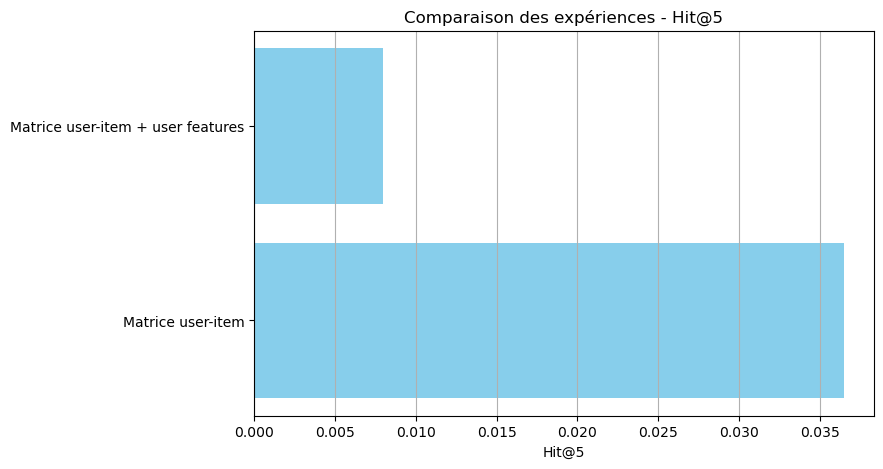

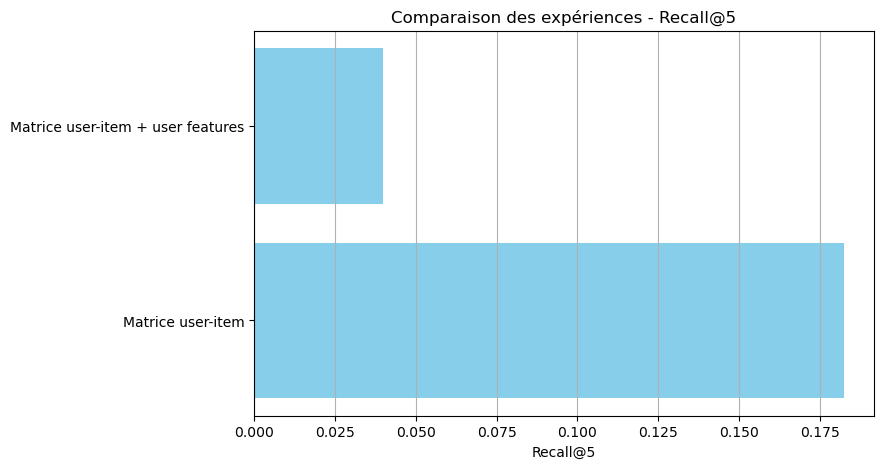

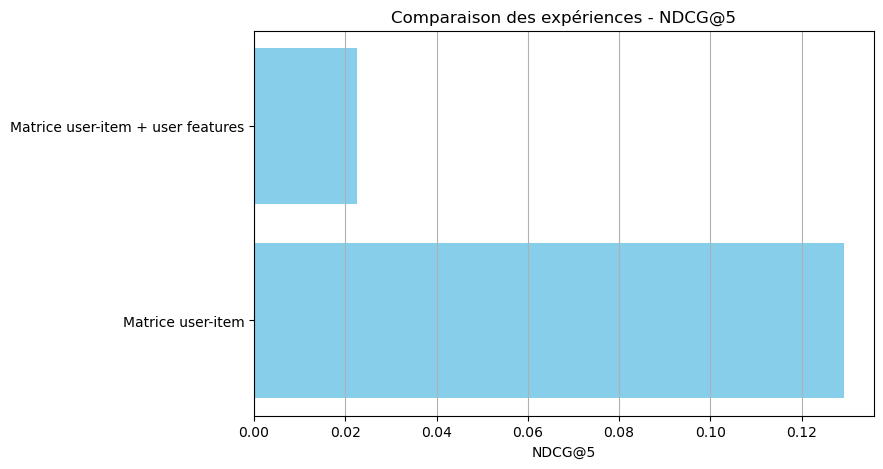

In [52]:
results_df = plot_experiments_results()